# Realimentação de estados (continuação)

## Problemas mais realistas

O exemplo anterior ilustra bem a solução do problema de realimentação de estados. Porém, ele é simples demais:
* Ele é de ordem baixa (2). Na prática, os sistemas podem ser de ordem bem mais elevada
* Em um problema de ordem mais alta, o trabalho seria muito maior e a solução desenvolvida, inviável
* Além disso, em um problema real temos também que nos preocupar com questões numéricas de arredondamento.

## Forma canônica de controlador

A primeira forma de lidar com problemas de ordem mais alta é transformar o sistema para forma canônica de controlador. 

Usar essa forma é vantajoso porque ela simplifica as equações dos ganhos na hora que igualamos os polinômios desejado e de projeto. Isso permite encontrar os ganhos com equações mais simples, geralmente fazendo substituições sucessivas.

Normalmente, a forma mais fácil de mudar para a forma de controlador é achando a função de transferência do sistema e usando as regras práticas de inspeção do numerador e denominador. 

Isso pode ser um pouco trabalhoso para sistemas de ordem elevada.

## Método de Ackermann

Uma maneira mais direta e geral de projetar a realimentação de estados é usar o método de Ackerman. Ele consiste de aplicar a expressão:
$$
\begin{align}
    \mathbf{K} = \left[\begin{array}{ccccc}0&0&\ldots & 0 & 1\end{array}\right]\mathbf{\mathcal{C}}^{-1}\alpha_c(\mathbf{F})
\end{align}
$$
onde $\mathbf{\mathcal{C}}$ é a matriz de controlabilidade do sistema
$$
\begin{align}
    \mathbf{\mathcal{C}} = \left[\begin{array}{ccccc}\mathbf{G}&\mathbf{FG}&\ldots & \mathbf{F}^{n-2}\mathbf{G} & \mathbf{F}^{n-1}\mathbf{G}\end{array}\right]
\end{align}
$$
e $\alpha_c(\mathbf{F})$ é uma matriz construída pela expressão:
$$
\begin{align}
    \alpha_c(\mathbf{F}) = \mathbf{F}^{n}+\alpha_1\mathbf{F}^{n-1}+\alpha_2\mathbf{F}^{n-2}+\ldots++\alpha_n\mathbf{I}
\end{align}
$$

Note que $\alpha_c(\mathbf{F})$ é o polinômio de malha fechado desejado, mas no lugar de $s$ temos a matriz $\mathbf{F}$ de malha aberta do sistema. 

O método é trabalhoso, mas fácil de implementar no computador. Em Python temos a função "acker()" da biblioteca *control* que faz o processo automaticamente (sem precisar fornecer a forma de controlador), que funciona bem para sistemas de até 10a ordem e preferencialmente com pólos de malha fechada não-repetidos.

Para problemas mais complexos, recomenda-se o uso da função "place()" da biblioteca *control*, ou "place_poles()" da biblioteca *scipy.signal*.

Nota: essas funções só funcionam para problemas numéricos. Não se recomenda utilizá-las com objetos simbólicos. 

## Exemplo:

<p align="center">
<img src="Ex7.16.svg" width="80%">
</p>

In [1]:
import numpy as np
import sympy as sp

# Define os símbolos
w0 = sp.symbols('w0',real=True)

# Define as matrizes do sistema
F = sp.Matrix([[0,1],[-w0**2,0]])
G = sp.Matrix([[0],[1]])

In [7]:
# Matriz de controlabilidade
C = sp.Matrix.hstack(G,F*G)    # Fazemos o produto normal. hstack() é pra concatenar as matrizes horizontalmente
C

Matrix([
[0, 1],
[1, 0]])

In [5]:
# Matriz Alpha, do polinômio desejado. Calcule o polinômio e no lugar do 's' coloque 'F'
Alpha = F**2 + 4*w0*F + 4*w0**2*sp.eye(2)
Alpha

Matrix([
[ 3*w0**2,    4*w0],
[-4*w0**3, 3*w0**2]])

In [10]:
# Fórmula de Ackermann
K = (sp.Matrix([0,1]).T) * C.inv() * Alpha  # Lembre-se que o Sympy requer o transposto para criar um vetor linha
K

Matrix([[3*w0**2, 4*w0]])

Eis um fato interessante: Ackermann permite posicionar os pólos de malha fechada **em qualquer lugar desejado**, mas isso só é possível se a matriz de controlabilidade possuir inversa.

Isso é relativamente interessante, comparado por exemplo, à técnica do LGR, onde o posicionamento dos pólos fica restrito ao lugar geométrico. No entanto, lembre-se que estamos sob uma hipótese forte de que todos os estados estão disponíveis para realimentação. 

## Exemplo:
<p align="center">
<img src="Ex7.17.svg" width="80%">
</p>

Abaixo apenas o item (b), resolvendo direto com acker()

In [16]:
import control as ct

A = np.matrix([[-7,1],[-12,0]])
z0 = 2
B = np.matrix([[1],[-z0]])
C = np.matrix([1,0])
D = 0

sys = ct.ss(A,B,C,D)
xi = 0.5
wn = 2
polo = -xi*wn+1j*wn*np.sqrt(1-xi**2)
K = ct.acker(A,B,[polo, np.conj(polo)])
K

array([[-3.8,  0.6]])

Execute novamente o código com $z_0=3$ para verificar a variação dos ganhos como no livro. Espera-se que haja um aumento significativo nos ganhos. 

Quando um polo e um zero tendem a se cancelar, o sistema tende a perder controlabilidade e isso torna os ganhos mais altos e, consequentemente, o controle fica mais "caro" (puxa mais energia). Vale a observação do livro:

**"O sistema tem que trabalhar com mais força para conseguir o controle quando a controlabilidade é fraca."**

Além disso:

**"Mover os polos em um longo caminho requer grandes ganhos."**

Isso é observado quando um sistema é naturalmente lento e tentamos deixá-lo mais rápido. Isso normalmente resulta em ganhos grandes (em módulo), o que resulta novamente em um controle "caro".

## Exercício

Use Ackermann para projetar um controlador para o sistema
$$
\begin{align}
    G(s) &= \frac{30}{s(s+1)^2}
\end{align}
$$

Posicione os dominantes em $-4\pm j4$.


In [65]:
import numpy as np
import control as ct

In [ ]:
F = np.array([[-2,-1,0],[1,0,0],[0,1,0]])
G = np.array([[1],[0],[0]])

In [4]:
alpha = np.convolve([1, 4-4j],[1, 4+4j])
alpha = np.convolve(alpha,[1,12])
alpha

array([  1.+0.j,  20.+0.j, 128.+0.j, 384.+0.j])

In [9]:
K = ct.acker(F,G,[-12,-4+4j,-4-4j])
K

array([[ 18., 127., 384.]])

In [22]:
#C=ct.ctrb(F,G)

In [29]:
C=np.concatenate([G,F@G,(F@F)@G],axis=1)
#C
iC=np.linalg.inv(C)
#iC
alphaF = F@F@F +   20*(F@F)+ 128.*F+ 384*np.eye(3)
#alphaF
Kf =  (np.array([[0,0,1]]) @ iC) @ alphaF
Kf

array([[ 18., 127., 384.]])

In [31]:
Fmf = F-G@K
Gmf = np.zeros((3,1))
Hmf = np.eye(3)
Jmf = np.zeros((3,1))
sys = ct.ss(Fmf,Gmf,Hmf,Jmf)
print(sys)

<LinearIOSystem>: sys[3]
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[ -20. -128. -384.]
     [   1.    0.    0.]
     [   0.    1.    0.]]

B = [[0.]
     [0.]
     [0.]]

C = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]]



In [47]:
resposta = ct.initial_response(sys,X0=[1,-1,2])

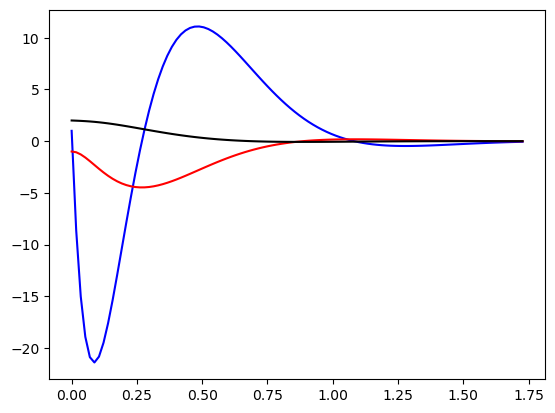

In [48]:
from matplotlib import pyplot as plt
plt.plot(resposta.t,resposta.y[0],'b',
        resposta.t,resposta.y[1], 'r',
        resposta.t,resposta.y[2], 'k')

In [55]:
K[0]

array([ 18., 127., 384.])

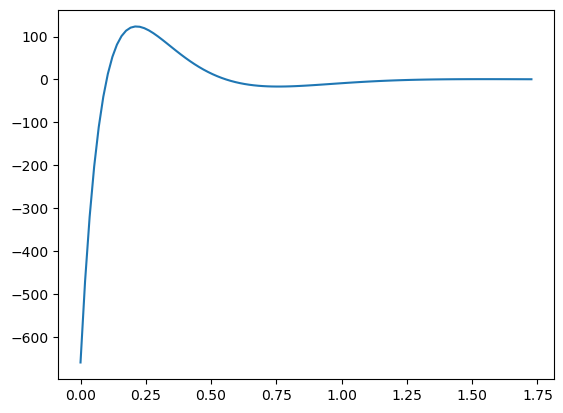

In [58]:
u = -K[0][0]*resposta.y[0]-K[0][1]*resposta.y[1]-K[0][2]*resposta.y[2]
plt.plot(resposta.t,u)